In [1]:
from ase.build import bulk
from ase.calculators.lj  import LennardJones
from ase.calculators.emt import EMT
from ase.calculators.eam import EAM
from ase.phonons import Phonons
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
calculator_EAM = EAM(potential='EAM_potentials/Al99.eam.alloy')

# Find Equilibrium Lattice Parameters

In [26]:
aVec = np.linspace(4.0,4.1,200)
aVec = np.linspace(4.045,4.055,20)
energies_EAM = []
for a in aVec:
    atoms = bulk('Al', 'fcc', a=a)
    atoms.set_calculator(calculator_EAM)
    energies_EAM.append(atoms.get_potential_energy())

4.050263157894737


Text(0.5, 1.0, 'Equilibrium Lattice Parameter for FCC Aluminum')

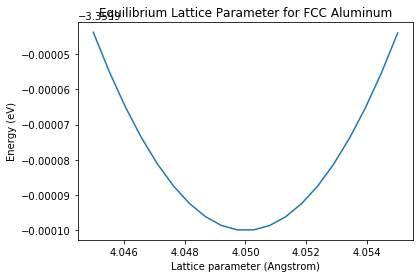

In [27]:
eqLatticeCoeff = [aVec[i] for i in range(len(aVec)) if energies_EAM[i] == min(energies_EAM)][0]
print(eqLatticeCoeff)
plt.plot(aVec,energies_EAM,label='EAM')
plt.xlabel('Lattice parameter (Angstrom)')
plt.ylabel('Energy (eV)')
plt.title('Equilibrium Lattice Parameter for FCC Aluminum')

# Find the LJ Parameters to Match EAM phonon distribution

In [28]:
def getPhonons(supercell_N, kPoint_N, calculator, atoms):
    ph = Phonons(atoms, calculator, supercell=(supercell_N, supercell_N, supercell_N), delta=0.001)
    ph.run()
    ph.read(acoustic=True)
    ph.clean()
    return ph.get_dos(kpts=(kPoint_N, kPoint_N, kPoint_N)).sample_grid(npts=500, width=1.5e-3)

def normalize(x,y):
    invNorm = 1.0/np.trapz(y,x)
    return [yVal*invNorm for yVal in y]

def getDiff(x,y1,y2):
    diffs = []
    for i in range(len(y1)):
        diffs.append(abs(y1[i]-y2[i]))
    return np.trapz(diffs,x)

atoms = bulk('Al', 'fcc', a=eqLatticeCoeff)
supercell_N = 5
kPoint_N    = 16

### Get the EAM phonon distribution - this is what we'll compare against

In [29]:
%%capture
output_EAM = getPhonons(supercell_N,kPoint_N,calculator_EAM,atoms)
energy_EAM = output_EAM.energy
dos_EAM = normalize(energy_EAM,output_EAM.weights[0])

### Sweep through all epsilon and sigma values, find where min difference is

In [30]:
%%capture
epsilonVec = np.linspace(0.00145,0.0015,50)
sigmaVec   = np.linspace(3.52,3.54,50)

epsilonVec = [0.0014611]
sigmaVec= [3.5333333333333]
energyVec = []
bigVec = []
diffVec = []
comboVec = []
for epsilon in epsilonVec:
    for sigma in sigmaVec:
        calculator_LJ = LennardJones(epsilon=epsilon,sigma=sigma)
        output_LJ = getPhonons(supercell_N,kPoint_N,calculator_LJ,atoms);
        energy_LJ = output_LJ.energy
        dos_LJ = normalize(energy_LJ,output_LJ.weights[0])

        f = interpolate.interp1d(energy_LJ,dos_LJ,bounds_error=False,fill_value=0.0)
        dos_LJ_final = f(energy_EAM)

        bigVec.append(f)
        diffVec.append(getDiff(energy_EAM,dos_EAM,dos_LJ_final))
        comboVec.append([epsilon,sigma])
        #plt.plot(energy_EAM,dos_LJ_final,label='epsilon='+str(epsilon))
plt.legend(loc='best')

### Plot the EAM phonon distribution and the best LJ phonon distribution to compare them

Best epsilon:  0.0014611
Best sigma:    3.5333333333333


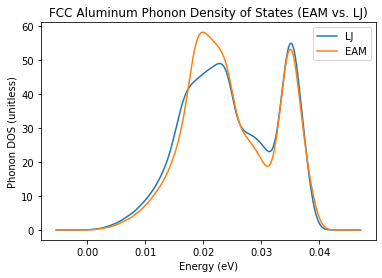

In [31]:
closestVal = [(i,comboVec[i]) for i in range(len(comboVec)) if diffVec[i] == min(diffVec) ]
indexClosestVal = closestVal[0][0]
plt.plot(energy_EAM,bigVec[indexClosestVal](energy_EAM),label='LJ')
plt.plot(energy_EAM,dos_EAM,label='EAM')
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (unitless)')
plt.title('FCC Aluminum Phonon Density of States (EAM vs. LJ)')
epsilon = closestVal[0][1][0]
sigma   = closestVal[0][1][1]
print('Best epsilon: ',epsilon)
print('Best sigma:   ',sigma)

In [32]:
f = open("Al_PhononDists_EAM_LJ.py", "w")
f.write("Al_PhononDOS_x = "+str(list(energy_EAM))+'\n')
f.write("Al_PhononDOS_EAM = "+str(list(dos_EAM))+'\n')
f.write("Al_PhononDOS_LJ = "+str(list(bigVec[indexClosestVal](energy_EAM)))+'\n')
f.close()

# Check convergence of k-point mesh

### EAM

In [9]:
%%capture
supercell_N = 6
nkVec = [6,8,14,16]
EAM_kConvergence_dosVec = []
EAM_kConvergence_energyVec = []
for nk in nkVec:
    output_EAM = getPhonons(supercell_N,nk,calculator_EAM,atoms)
    energy_EAM = output_EAM.energy
    dos_EAM = normalize(energy_EAM,output_EAM.weights[0])
    EAM_kConvergence_energyVec.append(energy_EAM)
    EAM_kConvergence_dosVec.append(dos_EAM)

Text(0.5, 1.0, 'Convergence of k-Points for Phonon DOS for FCC Aluminum (EAM)')

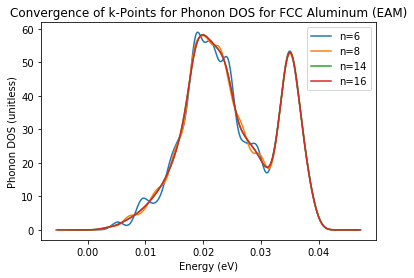

In [10]:
for i in range(len(nkVec)):
    plt.plot(EAM_kConvergence_energyVec[i],EAM_kConvergence_dosVec[i],label='n='+str(nkVec[i]))

plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (unitless)')
plt.title('Convergence of k-Points for Phonon DOS for FCC Aluminum (EAM)')

### Lennard Jones

In [11]:
%%capture
supercell_N = 5
nkVec = [6,8,14,16]
calculator_LJ = LennardJones(epsilon=epsilon, sigma=sigma)
LJ_kConvergence_dosVec = []
LJ_kConvergence_energyVec = []
for nk in nkVec:
    output_LJ = getPhonons(supercell_N,nk,calculator_LJ,atoms)
    energy_LJ = output_LJ.energy
    dos_LJ = normalize(energy_LJ,output_LJ.weights[0])
    LJ_kConvergence_energyVec.append(energy_LJ)
    LJ_kConvergence_dosVec.append(dos_LJ)

Text(0.5, 1.0, 'Convergence of k-Points for Phonon DOS for FCC Aluminum (LJ)')

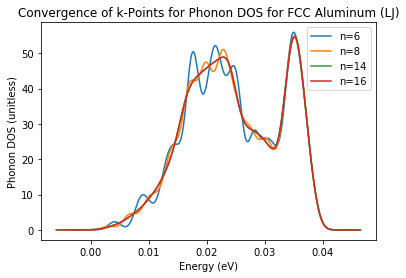

In [12]:
for i in range(len(nkVec)):
    plt.plot(LJ_kConvergence_energyVec[i],LJ_kConvergence_dosVec[i],label='n='+str(nkVec[i]))

plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (unitless)')
plt.title('Convergence of k-Points for Phonon DOS for FCC Aluminum (LJ)')


### This makes me feel like nk=16 is sufficient for this problem

# Check Convergence of Supercell Size

### EAM

In [13]:
%%capture
kPoint_N    = 16
supercell_N_Vec = [3,4,5,6]
supercell_EAM_dosVec = []
supercell_EAM_energyVec = []
for supercell_N in supercell_N_Vec:
    output_EAM = getPhonons(supercell_N,kPoint_N,calculator_EAM,atoms)
    energy_EAM = output_EAM.energy
    dos_EAM = normalize(energy_EAM,output_EAM.weights[0])
    supercell_EAM_energyVec.append(energy_EAM)
    supercell_EAM_dosVec.append(dos_EAM)

Text(0.5, 1.0, 'Supercell Size Convergence of Phonon DOS for FCC Aluminum (EAM)')

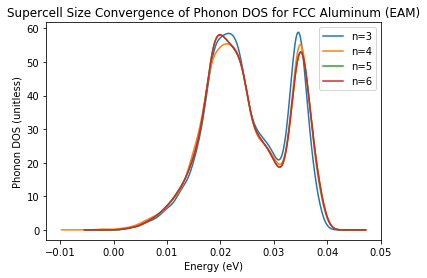

In [14]:
for i in range(len(supercell_N_Vec)):
    plt.plot(supercell_EAM_energyVec[i],supercell_EAM_dosVec[i],label='n='+str(supercell_N_Vec[i]))

plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (unitless)')
plt.title('Supercell Size Convergence of Phonon DOS for FCC Aluminum (EAM)')

### Lennard Jones

In [15]:
%%capture
kPoint_N    = 16
supercell_N_Vec = [3,4,5,6]
calculator_LJ = LennardJones(epsilon=epsilon, sigma=sigma)
supercell_LJ_dosVec = []
supercell_LJ_energyVec = []
for supercell_N in supercell_N_Vec:
    output_LJ = getPhonons(supercell_N,kPoint_N,calculator_LJ,atoms)
    energy_LJ = output_LJ.energy
    dos_LJ = normalize(energy_LJ,output_LJ.weights[0])
    supercell_LJ_energyVec.append(energy_LJ)
    supercell_LJ_dosVec.append(dos_LJ)

Text(0.5, 1.0, 'Supercell Size Convergence of Phonon DOS for FCC Aluminum (LJ)')

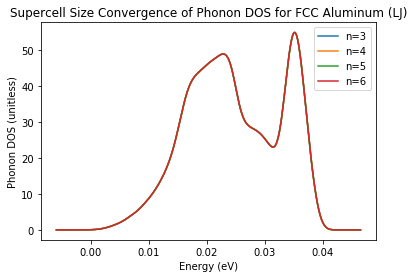

In [16]:
for i in range(len(supercell_N_Vec)):
    plt.plot(supercell_LJ_energyVec[i],supercell_LJ_dosVec[i],label='n='+str(supercell_N_Vec[i]))

plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (unitless)')
plt.title('Supercell Size Convergence of Phonon DOS for FCC Aluminum (LJ)')

### This makes me feel that cellsize = 5x5x5 is sufficient

# Thermal Expansion

Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl
Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl
Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl


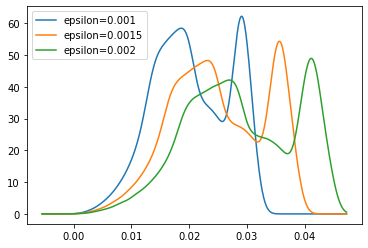

In [17]:
sigma = 3.5333333333333


epsilonVec = [0.0010,0.0015,0.0020]
energyVec = []
bigVec = []
diffVec = []
comboVec = []
for epsilon in epsilonVec:
    calculator_LJ = LennardJones(epsilon=epsilon,sigma=sigma)
    output_LJ = getPhonons(supercell_N,kPoint_N,calculator_LJ,atoms);
    energy_LJ = output_LJ.energy
    dos_LJ = normalize(energy_LJ,output_LJ.weights[0])

    f = interpolate.interp1d(energy_LJ,dos_LJ,bounds_error=False,fill_value=0.0)
    dos_LJ_final = f(energy_EAM)

    bigVec.append(f)
    diffVec.append(getDiff(energy_EAM,dos_EAM,dos_LJ_final))
    comboVec.append([epsilon,sigma])
    plt.plot(energy_EAM,dos_LJ_final,label='epsilon='+str(epsilon))
plt.legend(loc='best')

Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl
Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl
Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl


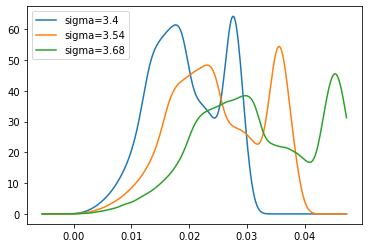

In [18]:
epsilon = 0.0014611
sigmaVec= [3.40,3.54,3.68]

energyVec = []
bigVec = []
diffVec = []
comboVec = []
for sigma in sigmaVec:
    calculator_LJ = LennardJones(epsilon=epsilon,sigma=sigma)
    output_LJ = getPhonons(supercell_N,kPoint_N,calculator_LJ,atoms);
    energy_LJ = output_LJ.energy
    dos_LJ = normalize(energy_LJ,output_LJ.weights[0])

    f = interpolate.interp1d(energy_LJ,dos_LJ,bounds_error=False,fill_value=0.0)
    dos_LJ_final = f(energy_EAM)

    bigVec.append(f)
    diffVec.append(getDiff(energy_EAM,dos_EAM,dos_LJ_final))
    comboVec.append([epsilon,sigma])
    plt.plot(energy_EAM,dos_LJ_final,label='sigma='+str(sigma))
plt.legend(loc='best')

### Check if LJ still matches after thermal expansion

In [19]:
epsilon = 0.0014611
sigma   = 3.5333333
calculator_LJ = LennardJones(epsilon=epsilon,sigma=sigma)

# eqLatticeCoeff = 4.050101

In [20]:
%%capture
energyVec = []
LJVec     = []
EAMVec    = []
aVec      = [4.05,4.06,4.07,4.09,4.11]

for aVal in aVec:
    atoms = bulk('Al', 'fcc', a=aVal)
    
    output_EAM = getPhonons(supercell_N,kPoint_N,calculator_EAM,atoms)
    energy_EAM = output_EAM.energy
    dos_EAM = normalize(energy_EAM,output_EAM.weights[0])
    energyVec.append(energy_EAM)
    
    output_LJ = getPhonons(supercell_N,kPoint_N,calculator_LJ,atoms);
    energy_LJ = output_LJ.energy
    dos_LJ = normalize(energy_LJ,output_LJ.weights[0])

    f = interpolate.interp1d(energy_LJ,dos_LJ,bounds_error=False,fill_value=0.0)
    dos_LJ_final = f(energy_EAM)

    LJVec.append(f)
    EAMVec.append(dos_EAM)


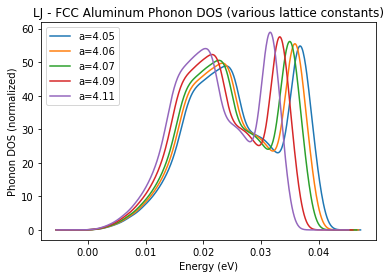

Text(0, 0.5, 'Phonon DOS (normalized)')

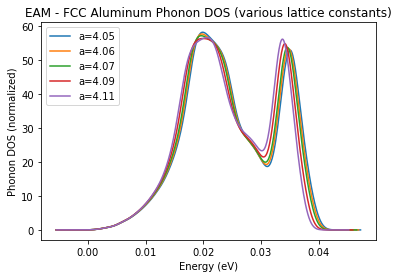

In [21]:
plt.title('LJ - FCC Aluminum Phonon DOS (various lattice constants)')
for i,aVal in enumerate(aVec):
    plt.plot(energyVec[i],LJVec[i](energy_EAM),label='a='+str(aVal))  
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (normalized)')
plt.show()

plt.title('EAM - FCC Aluminum Phonon DOS (various lattice constants)')
for i,aVal in enumerate(aVec):
    plt.plot(energyVec[i],EAMVec[i],label='a='+str(aVal))
    plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('Phonon DOS (normalized)')
